#Kaggle Challenger: Predicting the survivors in the Titanic Disaster

##Starting the libraries

In [223]:
!pip install plotly --upgrade

In [224]:
!pip install category_encoders --upgrade

In [272]:
!pip install lightgbm --upgrade

     |████████████████████████████████| 2.0 MB 4.8 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import keras
from zipfile import ZipFile
import re
import plotly.figure_factory as ff
import plotly.graph_objects as go
import sklearn.preprocessing 
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
sns.set(style="darkgrid")

In [226]:
zf = ZipFile("/content/titanic.zip", "r")
zf.extractall("/content/")
zf.close()


### Defined functions

In [227]:
import copy

def concat_df(df1, df2):
  #Concatenating two dataframes and reset the index remain
  return pd.concat([df1, df2]).reset_index(drop=True)


def title_search(df):
  # Generates an array with the titles given by each passenger in its names
  string = ''
  array = []
  count = 0

  for i in range(len(df)):
    for x in df["Name"][i]:
      if x == ',' or x=='.' :
        count+=1
      if count==1:
        if x != ' ' and x != ',':
          string+=x
      if string=='theCountess':
        string = 'Countess'
    array.append(string)
    count = 0
    string = ''
  array = list(set(array))
  return array



def name_for_title(df, inplace=False):
  # Swap the name column, to the title
  if inplace:
    df_copy = copy.deepcopy(df)
  else:
    df_copy = df
  
  array = title_search(df_copy)
  for i in range(len(df_copy)):
    for x in df_copy["Name"][i]:
      for z in array:
        pattern = r'\b{}\.'.format(z)
        if re.findall(pattern, df_copy["Name"][i]):
          df_copy["Name"][i] = z
  df_copy.rename(columns={"Name":"Title"}, inplace = True)

  return df_copy



def clean_cabin(df):
  # fill the unfilled values with the U of Unknown, and remove the numbers in
  # the cabin identification.

  df['Cabin'].fillna('U', inplace=True)

  lista = []

  for i in df["Cabin"]:
    lista.append(i[0])
    lista = list(set(lista))
    lista.sort()

  for i in range(len(df)):
    for j in lista:
      if j in df["Cabin"][i]:
        df["Cabin"][i] = j

  return df

  # scales the numerical features
def numerical_scaling(df, numerical_array):
  scaler = StandardScaler()
  scaler_t = scaler.fit_transform(np.array(df[numerical_array]))

  df[numerical_array] = pd.DataFrame(scaler_t, columns=numerical_array)

  return df  


  # applies the onehotencoder to the categorical variables in the dataset
def ohe_categorical(df, category_arrays, inplace=False):
  OHE = ce.OneHotEncoder(cols=category_arrays,
  use_cat_names=True          
  )

  df= OHE.fit_transform(df)

  return df


##Starting the dataframes

Calling the data train, test and creating the data union, that concatenates the first and second one, and dropping the survived column of union data, we obtain

In [228]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_union = concat_df(df_train, df_test)
df_union.drop(columns=["Survived"], inplace=True)

name_for_title(df_union)
name_for_title(df_train)
name_for_title(df_test)

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,Mr,male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,Mrs,female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,Mr,male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,Mr,male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,Mrs,female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,Mr,male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,Dona,female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,Mr,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,Mr,male,NaN,0,0,359309,8.0500,NaN,S


In [229]:
def replace_titles(df):
  title=df['Title']
  if title in ['Sir', 'Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
    return 'Mr'
  elif title in ['Lady','Dona', 'Countess', 'Mme']:
    return 'Mrs'
  elif title in ['Mlle', 'Ms']:
    return 'Miss'
  elif title=='Dr':
    if df['Sex'] == 'male':
      return 'Mr'
    else:
      return 'Mrs'
  else:
    return title

In [230]:
df_union['Title'] = df_union.apply(replace_titles, axis=1)
df_train['Title'] = df_train.apply(replace_titles, axis=1)
df_test['Title'] = df_test.apply(replace_titles, axis=1)

In [231]:
df_union.groupby("Title").size()

Title
Master     61
Miss      264
Mr        782
Mrs       202
dtype: int64

First, we need if there is any duplicated data. To identify that, we just need to check by the id of each passenger, considering that this is a unique value given to each passenger.

In [232]:
df_union[df_union["PassengerId"].duplicated()]

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Let's check if there's unfilled data

In [233]:
df_union.isnull().sum()

PassengerId       0
Pclass            0
Title             0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

To deal with the cabin columns, we will fill the nan values with U of Unknown. We also remove the number of the cabin, including only the letter that identified each cabin.

In [234]:
clean_cabin(df_train)
clean_cabin(df_test)
clean_cabin(df_union)

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,Mr,male,22.0,1,0,A/5 21171,7.2500,U,S
1,2,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C,C
2,3,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
3,4,1,Mrs,female,35.0,1,0,113803,53.1000,C,S
4,5,3,Mr,male,35.0,0,0,373450,8.0500,U,S
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,Mr,male,NaN,0,0,A.5. 3236,8.0500,U,S
1305,1306,1,Mrs,female,39.0,0,0,PC 17758,108.9000,C,C
1306,1307,3,Mr,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,U,S
1307,1308,3,Mr,male,NaN,0,0,359309,8.0500,U,S


In [235]:
# Checking each group quantity
df_union.groupby("Cabin").size()

Cabin
A      22
B      65
C      94
D      46
E      44
F      18
G       5
T       1
U    1014
dtype: int64

It is a problem to our analysis a category with so low occurrency, such G and T. In order to solve this problem, let set G and T as the most frequent category, U.

In [236]:
df_union_t = copy.deepcopy(df_union)

In [237]:
df_union.loc[(df_union['Cabin']=='T') | (df_union['Cabin'] == 'G'), "Cabin"] = 'U'
df_train.loc[(df_train['Cabin']=='T') | (df_train['Cabin'] == 'G'), "Cabin"] = 'U'
df_test.loc[(df_test['Cabin']=='T') | (df_test['Cabin'] == 'G'), "Cabin"] = 'U'

In [238]:
df_union_t.groupby("Cabin").size()

Cabin
A      22
B      65
C      94
D      46
E      44
F      18
G       5
T       1
U    1014
dtype: int64

In [239]:
df_test.groupby("Cabin").size()

Cabin
A      7
B     18
C     35
D     13
E     11
F      6
U    328
dtype: int64

We can use a countplot to identify how much have survived in each cabin

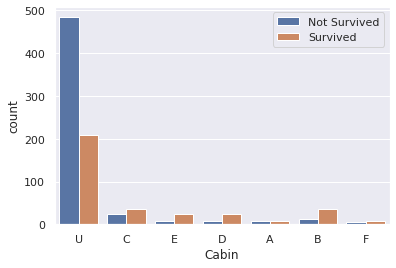

In [240]:
sns.countplot(data=df_train, x='Cabin', hue='Survived')
plt.legend(['Not Survived', 'Survived'], loc = 'upper right');

Now, let's look if there is unfilled data

In [241]:
df_union.isnull().sum()

PassengerId      0
Pclass           0
Title            0
Sex              0
Age            263
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin            0
Embarked         2
dtype: int64

Now, We will deal with the Age variable. To decide what statical metric we will use to fill the unfilled age values, we will look the variable distribution

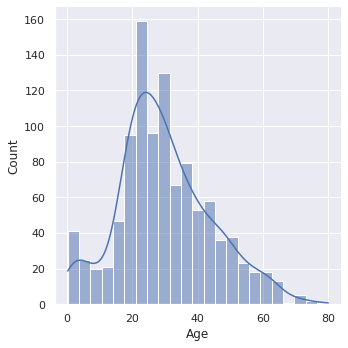

In [242]:
sns.displot(df_union["Age"], kde=True)

we can see that this distribution is quite spread out on the right, which can reinforce that using the median is a better idea. To help us to reach a conclude, let plot boxplot

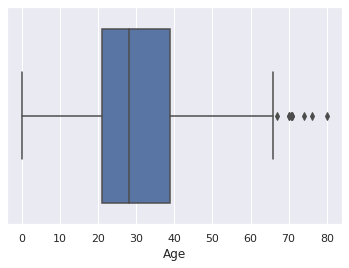

In [243]:
sns.boxplot(data=df_union, x="Age")

We can see that there's a huge number of values that could be identified as a outlier. Then, to finish, 

In [244]:
df_union["Age"].describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

We can see that the mean is more to the right of the median. This is due to the asymmetry of the distribution caused by the concentration of outliers. Since the median does not suffer from the same problem, it is a better alternative when dealing with distributions like that.


In [245]:
age_median = df_union['Age'].median()
df_union['Age'].fillna(age_median, inplace=True)
df_train['Age'].fillna(age_median, inplace=True)
df_test['Age'].fillna(age_median, inplace=True)

Now, we can concatenates all the information in one single interactive figure

In [246]:
px.histogram(df_train, x="Age", color="Survived", marginal='box', color_discrete_map={0:'darkcyan', 1:'firebrick'}, opacity=0.6, template='seaborn')

By investigating if still there unfilled values, 

In [247]:
df_union.isnull().sum()

PassengerId    0
Pclass         0
Title          0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       2
dtype: int64

Due to the low incidence of unfilled values, we can choose without many consequences the second methods to fill them.

In [248]:
# Fare -> we will use the median
fare_median = df_union['Fare'].median()
df_union['Fare'].fillna(fare_median, inplace=True)
df_train['Fare'].fillna(fare_median, inplace=True)
df_test['Fare'].fillna(fare_median, inplace=True)

# Embarked -> we will use the mode
embarked_mode = df_union['Embarked'].mode()
for x, y in enumerate(embarked_mode):
  emb_mode = y

df_union['Embarked'].fillna(emb_mode, inplace=True)
df_train['Embarked'].fillna(emb_mode, inplace=True)
df_test['Embarked'].fillna(emb_mode, inplace=True)

In [249]:
df_union.isnull().sum()

PassengerId    0
Pclass         0
Title          0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

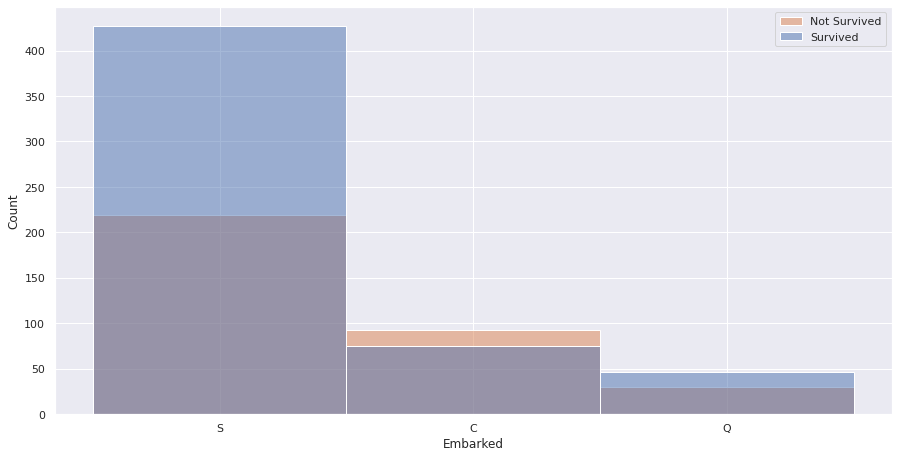

In [250]:
figs, axs = plt.subplots(figsize=(15,7.5), nrows=1, ncols=1, squeeze=False)
sns.histplot(data=df_train, x='Embarked', hue='Survived', ax=axs[0][0])
axs[0][0].legend(['Not Survived', 'Survived'], loc = 'upper right');

In [251]:
px.histogram(df_train, x="Fare", color="Survived", marginal='box', color_discrete_map={0:'darkcyan', 1:'firebrick'}, opacity=0.6, template='seaborn')

We will create a new feature called FamilySize, this would be defined as the follows,

In [252]:
# defining the family size as a new column by
df_union['FamilySize'] = df_union["SibSp"] + df_union["Parch"] + 1
df_train['FamilySize'] = df_train["SibSp"] + df_train["Parch"] + 1
df_test['FamilySize'] = df_test["SibSp"] + df_test["Parch"] + 1

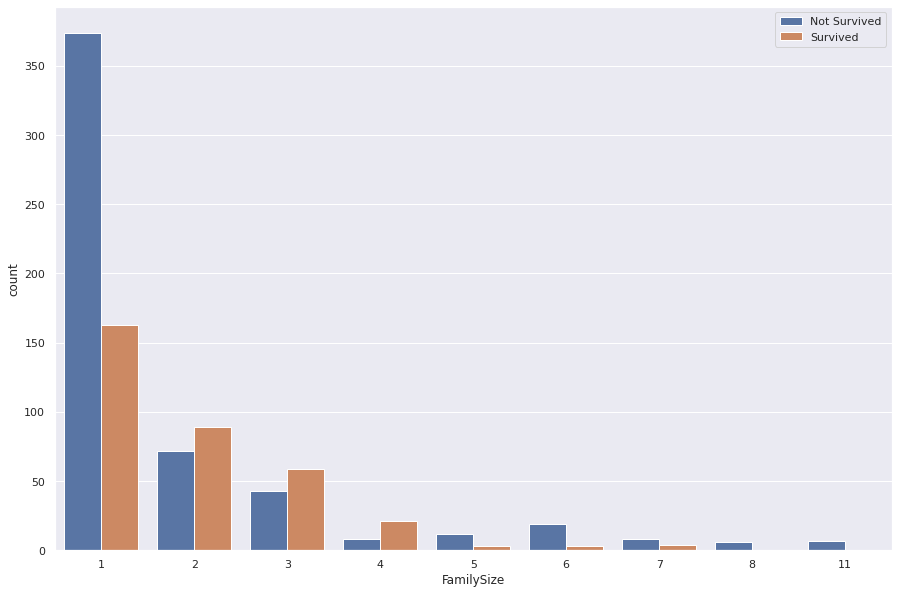

In [253]:
figs, axs = plt.subplots(figsize=(15,10), nrows=1, ncols=1, squeeze=False)
sns.countplot(data=df_train, x="FamilySize", hue='Survived')
axs[0][0].legend(['Not Survived', 'Survived'], loc = 'upper right');
plt.show()

In [254]:
px.histogram(df_train, x="FamilySize", color="Survived", marginal='box', pattern_shape="Sex", template='seaborn', opacity=0.9, histnorm='percent')

The fact that there are many different tickets makes our analysis difficult, so we will group them in the number of tickets that were distributed to passengers. This will considerably decrease the number of data we have to deal with in this feature.

We also can do the 

In [255]:
df_union['Ticket_Frequency'] = df_union.groupby('Ticket')['Ticket'].transform('count')
df_train['Ticket_Frequency'] = df_train.groupby('Ticket')['Ticket'].transform('count')
df_test['Ticket_Frequency'] = df_test.groupby('Ticket')['Ticket'].transform('count')

In [256]:
df_union

,PassengerId,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Ticket_Frequency
0,1,3,Mr,male,22.0,1,0,A/5 21171,7.2500,U,S,2,1
1,2,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C,C,2,2
2,3,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,1,1
3,4,1,Mrs,female,35.0,1,0,113803,53.1000,C,S,2,2
4,5,3,Mr,male,35.0,0,0,373450,8.0500,U,S,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,Mr,male,28.0,0,0,A.5. 3236,8.0500,U,S,1,1
1305,1306,1,Mrs,female,39.0,0,0,PC 17758,108.9000,C,C,1,3
1306,1307,3,Mr,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,U,S,1,1
1307,1308,3,Mr,male,28.0,0,0,359309,8.0500,U,S,1,1


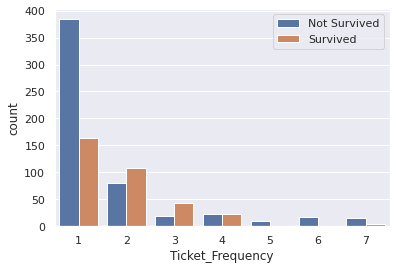

In [257]:
sns.countplot(data=df_train, x="Ticket_Frequency", hue='Survived')
plt.legend(['Not Survived', 'Survived'], loc = 'upper right')

We can classificate each passenger by their life stage: children, teenager, adult or aged

In [258]:
df_union.loc[df_union["Age"]<12, "LifeStage"] = "Children" 
df_union.loc[(df_union["Age"]>=12) & (df_union["Age"]<18 ), "LifeStage"] = "Teenager" 
df_union.loc[(df_union["Age"]>=18) & (df_union["Age"]<60 ), "LifeStage"] = "Adult" 
df_union.loc[(df_union["Age"]>=60), "LifeStage"] = "Aged"

# train data

df_train.loc[df_train["Age"]<12, "LifeStage"] = "Children" 
df_train.loc[(df_train["Age"]>=12) & (df_train["Age"]<18 ), "LifeStage"] = "Teenager" 
df_train.loc[(df_train["Age"]>=18) & (df_train["Age"]<60 ), "LifeStage"] = "Adult" 
df_train.loc[(df_train["Age"]>=60), "LifeStage"] = "Aged"


# test data


df_test.loc[df_test["Age"]<12, "LifeStage"] = "Children" 
df_test.loc[(df_test["Age"]>=12) & (df_test["Age"]<18 ), "LifeStage"] = "Teenager" 
df_test.loc[(df_test["Age"]>=18) & (df_test["Age"]<60 ), "LifeStage"] = "Adult" 
df_test.loc[(df_test["Age"]>=60), "LifeStage"] = "Aged"

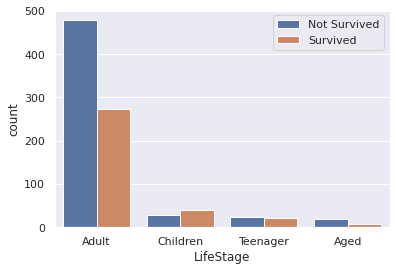

In [259]:
sns.countplot(data=df_train, x="LifeStage", hue='Survived')
plt.legend(['Not Survived', 'Survived'], loc = 'upper right');

We can go further, and plot the same graph but considering the sex of each one

In [260]:
px.histogram(
    df_train,
    x="LifeStage",
    color="Survived",
    pattern_shape="Sex",
    template='seaborn',
    opacity=0.9,
    histnorm='percent',
    category_orders={'LifeStage':['Children', 'Teenager', 'Adult', "Aged"]}
    )

To make a better visualization, 

In [261]:
px.parallel_categories(df_train, dimensions=["LifeStage", "Sex", "Survived"])

The graph above shows that the general trend for individuals at each stage of life is for females to survive, except for children. In the case of children, the probability seems to be more equally.

We can also check the relationship between surviving and ticket class

In [262]:
# creating a copy to plot Pclass as a categorical variable
df_train_copy = copy.deepcopy(df_train)
df_train_copy['Pclass'] = df_train_copy["Pclass"].map(str)

# plotting
px.histogram(
    df_train_copy,
    x="Pclass",
    color="Survived",
    template='seaborn',
    opacity=0.9,
    histnorm='percent',
    category_orders={"Pclass":["1","2","3"]}
    )

Which shows that people who bought the ticket referring to first class, have a high survival rate compared to those who bought third class.


Now, let's drop the columns that are not more useful such as SibSp, Parch and Ticket

In [263]:
# train data
df_train.drop(["SibSp", "Parch", "Ticket"], axis=1, inplace=True)

# test data
df_test.drop(["SibSp", "Parch", "Ticket"], axis=1, inplace=True)

# union data
df_union.drop(["SibSp", "Parch", "Ticket"], axis=1, inplace=True)

## Scaling Numerical Features

Among all the numerical attributes, the ones I think are needed to be scaled are "Age" and "Fare". This is because they have a wide distribution, and with a considerable number of outliers, mainly the "Fare" attribute.

In [264]:
# implementing standard scaler
num_array = ["Age", "Fare"]
# train
numerical_scaling(df_train, num_array)
# df_train
# test
numerical_scaling(df_test, num_array)

# df_union
numerical_scaling(df_union, num_array)

,PassengerId,Pclass,Title,Sex,Age,Fare,Cabin,Embarked,FamilySize,Ticket_Frequency,LifeStage
0,1,3,Mr,male,-0.581628,-0.503291,U,S,2,1,Adult
1,2,1,Mrs,female,0.658652,0.734744,C,C,2,2,Adult
2,3,3,Miss,female,-0.271558,-0.490240,U,S,1,1,Adult
3,4,1,Mrs,female,0.426099,0.383183,C,S,2,2,Adult
4,5,3,Mr,male,0.426099,-0.487824,U,S,1,1,Adult
...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,Mr,male,-0.116523,-0.487824,U,S,1,1,Adult
1305,1306,1,Mrs,female,0.736169,1.462034,C,C,1,3,Adult
1306,1307,3,Mr,male,0.697411,-0.503291,U,S,1,1,Adult
1307,1308,3,Mr,male,-0.116523,-0.487824,U,S,1,1,Adult


##Categorial Features

Analyzing the columns of the databases, we can see that the total of categorical attributes is 6, this is counting that the ticket class, given by the column "Pclass", despite being given in numbers, it behaves like a categorical attribute. The other numerical attributes have either already been scaled or they don't need to.

In [265]:
# turning Pclass as string

df_union["Pclass"] = df_union["Pclass"].apply(str)
df_train["Pclass"] = df_train["Pclass"].apply(str)
df_test["Pclass"] = df_test["Pclass"].apply(str)

Lets split the data into predictors and the target class

In [266]:
y_train = df_train.iloc[:, 1]
x_train = df_train.iloc[:, 2:]

# train_data
x_train_tr, x_train_te, y_train_tr, y_train_te = train_test_split(x_train, y_train, test_size=0.25, random_state=0)

####Applying the OneHotEncoder

In [267]:
x_train_tr = ohe_categorical(x_train_tr,
                 ["Pclass","Title","Sex","Cabin","Embarked","LifeStage"])

x_train_te = ohe_categorical(x_train_te,
                 ["Pclass","Title","Sex","Cabin","Embarked","LifeStage"])

In [268]:
df_test = ohe_categorical(df_test,
                          ["Pclass","Title","Sex","Cabin","Embarked","LifeStage"])

##The Classifier

In this part we will be concerned in what classifier is the best to deal with the problem. Among all the possibles classifiers, we choose to work with three them in: Random Forest, SVM and KNN. They are three classifiers with very different natures, and is oftenly recommended to small datasets, which could be interest to analyze in this problem.

###Random Forest

First, let's start by random forest classifier, with default parameters

In [307]:
df_rf_classifier = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, min_samples_leaf=1)
df_rf_classifier.fit(x_train_tr, y_train_tr)
df_rf_pred = df_rf_classifier.predict(x_train_te)

accuracy_score(df_rf_pred, y_train_te)

0.8385650224215246

We obtain 83,85% of accuracy. Lets start de GridSearch in order to find the best values for each parameters

In [306]:
rf_params = {'n_estimators':[100, 1000, 2000],
              'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, scoring='accuracy', cv=5) 
rf_grid_search.fit(x_train_tr, y_train_tr)
best_params = rf_grid_search.best_params_
best_result = rf_grid_search.best_score_

print(best_params)
print(best_result)

{'criterion': 'entropy', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 2000}
0.8413421613735832


with the best params estimated, we can train the classifier with them

In [313]:
rf_best = RandomForestClassifier(criterion='entropy', min_samples_leaf=5, min_samples_split=2, n_estimators=2000)
rf_best.fit(x_train_tr, y_train_tr)
rf_best_pred = rf_best.predict(x_train_te)

accuracy_score(rf_best_pred, y_train_te)

0.8251121076233184

It is important to emphasize that this value differs from the one obtained by GridSearch, as it also performs cross validation, which was not done in the last cell.


In [322]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
rf_best_cv = RandomForestClassifier(criterion='entropy', min_samples_leaf=5, min_samples_split=2, n_estimators=2000)
scores_rf = cross_val_score(rf_best_cv, x_train_tr, y_train_tr, cv=kfold)
final_score = scores_rf.mean()
final_score

0.8457711442786069

###SVM

In [323]:
from sklearn.svm import SVC

In [324]:
df_svc_classifier = SVC(C=1.0, kernel='rbf', tol=0.001)
df_svc_classifier.fit(x_train_tr, y_train_tr)
df_svc_pred = df_svc_classifier.predict(x_train_te)

accuracy_score(df_svc_pred, y_train_te)

0.820627802690583

In [329]:
svc_params = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc_grid_search = GridSearchCV(estimator=SVC(), param_grid=svc_params, scoring='accuracy', cv=5) 
svc_grid_search.fit(x_train_tr, y_train_tr)
best_params = svc_grid_search.best_params_
best_result = svc_grid_search.best_score_

print(best_params)
print(best_result)

{'C': 2.0, 'kernel': 'linear', 'tol': 0.0001}
0.8353720121198519


In [330]:
svc_best = SVC(tol=0.0001, C=2.0, kernel='linear')
svc_best.fit(x_train_tr, y_train_tr)
svc_best_pred = svc_best.predict(x_train_te)

accuracy_score(svc_best_pred, y_train_te)

0.7937219730941704

In [331]:
svc_best_cv = SVC(tol=0.0001, C=2.0, kernel='linear')
scores_svc = cross_val_score(svc_best_cv, x_train_tr, y_train_tr, cv=kfold)
final_score_svc = scores_svc.mean()
final_score_svc

0.8398009950248756

###kNN

In [332]:
from sklearn.neighbors import KNeighborsClassifier

In [333]:
df_knn_classifier = KNeighborsClassifier(n_neighbors=5, p=2)
df_knn_classifier.fit(x_train_tr, y_train_tr)
df_knn_pred = df_knn_classifier.predict(x_train_te)

accuracy_score(df_knn_pred, y_train_te)

0.8295964125560538

In [334]:
knn_params = {'n_neighbors': [3, 5, 10, 20],
              'p': [1, 2]}# p=1 and p=2 is manhattan and euclidean distance, respectively.


knn_grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, scoring='accuracy', cv=5) 
knn_grid_search.fit(x_train_tr, y_train_tr)
best_params = knn_grid_search.best_params_
best_result = knn_grid_search.best_score_

print(best_params)
print(best_result)

{'n_neighbors': 20, 'p': 1}
0.8263270115587475


In [335]:
knn_best_cv = KNeighborsClassifier(n_neighbors=20, p=1)
scores_knn = cross_val_score(knn_best_cv, x_train_tr, y_train_tr, cv=kfold)
final_score_knn = scores_knn.mean()
final_score_knn

0.8293532338308458

###Applying to the test data


In the end of the day, we obtain that the random forest performs better than the other ones. So lets choose this classifier to obtain the result of our competition.

We will use the already trained classifier `rf_best`, to obtain the estimations of survived or not passengers.

In [345]:
df_test

,PassengerId,Pclass_3,Pclass_2,Pclass_1,Title_Mr,Title_Mrs,Title_Miss,Title_Master,Sex_male,Sex_female,Age,Fare,Cabin_U,Cabin_B,Cabin_E,Cabin_A,Cabin_C,Cabin_D,Cabin_F,Embarked_Q,Embarked_S,Embarked_C,FamilySize,Ticket_Frequency,LifeStage_Adult,LifeStage_Aged,LifeStage_Teenager,LifeStage_Children
0,892,1,0,0,1,0,0,0,1,0,0.371062,-0.497413,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0
1,893,1,0,0,0,1,0,0,0,1,1.358985,-0.512278,1,0,0,0,0,0,0,0,1,0,2,1,1,0,0,0
2,894,0,1,0,1,0,0,0,1,0,2.544493,-0.464100,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
3,895,1,0,0,1,0,0,0,1,0,-0.221692,-0.482475,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
4,896,1,0,0,0,1,0,0,0,1,-0.616861,-0.417492,1,0,0,0,0,0,0,0,1,0,3,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,1,0,0,1,0,0,0,1,0,-0.142658,-0.493455,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
414,1306,0,0,1,0,1,0,0,0,1,0.726714,1.314435,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0
415,1307,1,0,0,1,0,0,0,1,0,0.687197,-0.507796,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
416,1308,1,0,0,1,0,0,0,1,0,-0.142658,-0.493455,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0


In [347]:
df_test_to_predict = df_test.drop(["PassengerId"], axis=1)
df_test_to_predict

,Pclass_3,Pclass_2,Pclass_1,Title_Mr,Title_Mrs,Title_Miss,Title_Master,Sex_male,Sex_female,Age,Fare,Cabin_U,Cabin_B,Cabin_E,Cabin_A,Cabin_C,Cabin_D,Cabin_F,Embarked_Q,Embarked_S,Embarked_C,FamilySize,Ticket_Frequency,LifeStage_Adult,LifeStage_Aged,LifeStage_Teenager,LifeStage_Children
0,1,0,0,1,0,0,0,1,0,0.371062,-0.497413,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0
1,1,0,0,0,1,0,0,0,1,1.358985,-0.512278,1,0,0,0,0,0,0,0,1,0,2,1,1,0,0,0
2,0,1,0,1,0,0,0,1,0,2.544493,-0.464100,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
3,1,0,0,1,0,0,0,1,0,-0.221692,-0.482475,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
4,1,0,0,0,1,0,0,0,1,-0.616861,-0.417492,1,0,0,0,0,0,0,0,1,0,3,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,0,0,1,0,0,0,1,0,-0.142658,-0.493455,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
414,0,0,1,0,1,0,0,0,1,0.726714,1.314435,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,0
415,1,0,0,1,0,0,0,1,0,0.687197,-0.507796,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0
416,1,0,0,1,0,0,0,1,0,-0.142658,-0.493455,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0


In [348]:
competition_result = rf_best.predict(df_test_to_predict)
competition_result

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

###Submission data frame

In [353]:
df_submission = pd.DataFrame(columns=['PassengerId', 'Survived'])
df_submission['PassengerId'] = df_test['PassengerId']
df_submission['Survived'] = competition_result
df_submission.to_csv("/content/submission.csv", header=True, index=False)
df_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


We need to scale the age and fare attributes and apply the OneHotEncoder to the categorical features

In [ ]:
!pip install category_encoders

In [ ]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

In [ ]:
# implementing standard scaler

# train
sc_age_train = StandardScaler()
train_data["Age"] = sc_age_train.fit_transform(train_data[["Age"]])

sc_fare_train = StandardScaler()
train_data["Fare"] = sc_fare_train.fit_transform(train_data[["Fare"]])

# test
sc_age_test = StandardScaler()
test_data["Age"] = sc_age_test.fit_transform(test_data[["Age"]])

sc_fare_test = StandardScaler()
test_data["Fare"] = sc_fare_test.fit_transform(test_data[["Fare"]])

In [ ]:
# implementing OneHotEncoder
OHE = ce.OneHotEncoder(cols=["Sex", "Embarked"], use_cat_names=True)
test_data = OHE.fit_transform(test_data)
train_data = OHE.fit_transform(train_data)

###Gender Submission Dataframe

In [352]:
# Base classifier

gender_data = pd.read_csv("gender_submission.csv")
gender_data

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
